In [12]:
import numpy as np
import os
import pickle
import data_process
import open3d as o3d
import copy
import numba
import random
from ops import Voxelization, nms_cuda

In [13]:
# dataset_root = '/media/chris/Workspace/Dataset/3d-object-detection-for-autonomous-vehicles/kitti_format/'
dataset_root = '/media/chris/Workspace/Dataset/kitti'
# dataset_root = '/media/chris/Workspace/Dataset/3d-object-detection-one_scene/kitti_format'
# dataset_root = '/media/chris/Workspace/Dataset/lyft'

# dataset_root = '/media/chris/胖虎的硬盘/kitti_format'
identifier = 'train'

In [14]:
# 读取pkl文件里的数据
data_content = data_process.read_pickle(os.path.join(dataset_root,f'lyft_infos_{identifier}.pkl'))
database_content = data_process.read_pickle(os.path.join(dataset_root,f'lyft_dbinfos_train.pkl'))

# data_content = data_process.read_pickle(os.path.join(dataset_root,f'kitti_infos_{identifier}.pkl'))
# database_content = data_process.read_pickle(os.path.join(dataset_root,f'kitti_dbinfos_train.pkl'))

# list(self.data_infos.keys())
# key_list = list(data_content.keys())
# print(data_content[key_list[]])
data_content

{0: {'image': {'image_path': 'training/image_2/000000.png',
   'image_shape': (370, 1224)},
  'calibration': {'P0': array([[707.0493,   0.    , 604.0814,   0.    ],
          [  0.    , 707.0493, 180.5066,   0.    ],
          [  0.    ,   0.    ,   1.    ,   0.    ],
          [  0.    ,   0.    ,   0.    ,   1.    ]]),
   'P1': array([[ 707.0493,    0.    ,  604.0814, -379.7842],
          [   0.    ,  707.0493,  180.5066,    0.    ],
          [   0.    ,    0.    ,    1.    ,    0.    ],
          [   0.    ,    0.    ,    0.    ,    1.    ]]),
   'P2': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01],
          [ 0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01],
          [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03],
          [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]),
   'P3': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02, -3.341081e+02],
          [ 0.000000e+00,  7.070493e+02,  1.805066e+02,  2.330660e+00],

In [15]:
# import cmath
# s = 0.87000000
# x1 = 6 + 6*np.cos(2*np.pi*(s-0.5))
# y1 = 3*np.sin(2*np.pi*s)

# print(x1)
# print(y1)

# b = -np.sqrt(36*(1 - y1**2/16))
# b
# # a = 15.526711513754837+2.47328848625
# # a

# random.seed(0)
# np.random.seed(0)

random.seed(2)
np.random.seed(2)
# torch.manual_seed(2023)

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_point_cloud(ax, points, title, axes=[0, 1, 2], point_size=0.2, xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    # 设置xyz三个轴的点云范围
    axes_limits = [
        [-50, 80], # X axis range
        [-100, 100], # Y axis range
        [-30, 50]    # Z axis range
    ]
    axes_str = ['X', 'Y', 'Z']
    # 禁止显示背后的网格
    ax.grid(False)
    # 创建散点图[1]:xyz数据集，[2]:点云的大小，[3]:点云的反射率数据,[4]:为灰度显示
    ax.scatter(*np.transpose(points[:, axes]), s=point_size, c=points[:, 3], cmap='gray')
    # 设置画板的标题
    ax.set_title(title)
    # 设置x轴标题
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    # 设置y轴标题
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        # 设置限制角度
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        # 将背景颜色设置为RGBA格式，目前的参数以透明显示
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # 设置z轴标题
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        # 2D限制角度，只有xy轴
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)



In [17]:
class BaseSampler():
    def __init__(self, sampled_list, shuffle=True):
        # print("========================")
        # print(sampled_list)
        self.total_num = len(sampled_list)
        # print("total_num",self.total_num)
        self.sampled_list = np.array(sampled_list)
        self.indices = np.arange(self.total_num)
        # 打乱顺序
        if shuffle:
            np.random.shuffle(self.indices)
        self.shuffle = shuffle
        self.idx = 0

    def sample(self, num):
        if self.idx + num < self.total_num:
            ret = self.sampled_list[self.indices[self.idx:self.idx+num]]
            self.idx += num
        else:
            ret = self.sampled_list[self.indices[self.idx:]]
            self.idx = 0
            if self.shuffle:
                np.random.shuffle(self.indices)
        return ret
    
class DataSet():
    # CLASSES = {
    #     'pedestrian': 0, 
    #     'truck': 1, 
    #     'car': 2,
    #     'bicycle':3
    #     }
    # CLASSES = {
    #     'pedestrian': 0, 
    #     'bicycle': 1, 
    #     'car': 2,
    #     }
    CLASSES = {
        'Pedestrian': 0, 
        'Cyclist': 1, 
        'Car': 2
        }
    def __init__(self, dataset_root,identifier) -> None:
        self.dataset_root = dataset_root
        self.identifier = identifier
        # 读取pkl文件内容   read the pkl file
        self.data_content = data_process.read_pickle(os.path.join(dataset_root,f'lyft_infos_{identifier}.pkl'))
        database_content = data_process.read_pickle(os.path.join(dataset_root,'lyft_dbinfos_train.pkl'))
        
        database_content = self.filter_by_difficulty(database_content)
        # print("==========================================")
        # print(database_content)
        # print("==========================================")
        
        self.key_list = list(self.data_content.keys())

        self.database_sampler = {}
        for class_name in self.CLASSES:
            print(database_content.keys())
            if class_name not in database_content.keys():
                continue
            self.database_sampler[class_name] = BaseSampler(database_content[class_name], True)
        # pass
    
    def filter_by_difficulty(self, database_content):
        # 1. filter_by_difficulty

        for k, v in database_content.items():
            database_content[k] = [item for item in v if item['difficulty'] != -1]
            
        # print(db_infos)
            # difficulty为-1也意味着无效的database
            # db_infos[k] = [item for item in v if item['difficulty'] != -1]

        # 2. filter_by_min_points, dict(Car=5, Pedestrian=10, Cyclist=10)
        filter_thrs = dict(Pedestrian=10, Cyclist=10, Car=15)
        for cat in self.CLASSES:
            print
            filter_thr = filter_thrs[cat]
            database_content[cat] = [item for item in database_content[cat] if item['num_points_in_gt'] >= filter_thr]
        
        return database_content

    def __getitem__(self, key):
        current_data = self.data_content[self.key_list[key]]
        # print("initial_data",current_data)
        data_dict = self.generate_data(current_data)
        # init_data = data_dict.deepcopy()
        # init_data = copy.deepcopy(data_dict)
        # print(init_pc)
        data_dict = self.data_augment_main(data_dict)
        # 
        # data_dict = self.rotation_data(data_dict, rotation_range)
        # print(data_dict)

        return data_dict
    
    def remove_invalid_data(self, annos):
        print("annos booxxxx",annos['bbox'])
        # keep_ids = [i for i, name in enumerate(annos_info['name']) if name != 'DontCare']
        # 移除掉无效的data, bbox的尺寸为-1则无效
        valid_rows_index = np.all(annos['bbox'] != -1, axis=1)        # 这一步错了
        # if np.all(valid_rows_index == False):
        #     return {}
        for k, v in annos.items():
            print(type(v))
            if type(v) == str:
                continue
            annos[k] = v[valid_rows_index]
        # annos = annos[valid_rows_index]
        return annos
    
    def remove_dont_care(self, annos_info):
        keep_ids = [i for i, name in enumerate(annos_info['name']) if name != 'DontCare']
        print(keep_ids)
        for k, v in annos_info.items():
            annos_info[k] = v[keep_ids]
        return annos_info
    
    # 生成用于数据增强的数据
    def generate_data(self, data_info):
        """_summary_

        Args:
            data_info (_type_): current data info from pkl.file

        Returns:
            dict: the input data
        """
        # 获取相对路径
        reduced_pc_filename = data_info['velodyne_path'].replace('velodyne','velodyne_reduced') # 用reduced point cloud
        # print(reduced_pc_filename)
        # print(reduced_pc_filename)
        # 绝对路径+相对路径
        reduced_pc_path = os.path.join(self.dataset_root, reduced_pc_filename)
        pc = data_process.get_lidar_points(reduced_pc_path)

        # get the image
        img = data_info['image']
        
        # print(pc)

        # get the calibration info
        calib = data_info['calibration']
        calib_R0_rect = calib['R0_rect']
        calib_tr_velo_to_cam = calib['Tr_lidar_to_cam']
        
        # get the annotation info
        annos = data_info['annos']
        # print(reduced_pc_filename)
        # 移除掉无效的data, bbox的尺寸为-1则无效
        annos = self.remove_dont_care(annos)
        # print("annos_info!!!!!!!!!!!!!",annos)

        # 类别
        annos_name = annos['name']
        # print(annos['name'])
        # box位置
        annos_box_location = annos['location']
        # box尺寸
        annos_box_dim = annos['dimensions']
        # rotation
        annos_box_rotation_y = annos['rotation_y']

        # print(annos)
        
        # 移除掉所有无效的data后不存在数据则pass
        # if len(annos) == 0:
        #     pass
        # print("boxxxxxxxxxxxxxxxxxxxxxxx",annos['bbox'])

        # After get the infomation, we can start to generate the data dict
        # 先将camera的box转成lidar坐标系下的3d box
        ground_truth_bboxes = np.concatenate([annos_box_location, annos_box_dim, annos_box_rotation_y[:, None]], axis=1).astype(np.float32)   #合并信息
        ground_truth_bboxes_3d = data_process.bbox_camera2lidar(ground_truth_bboxes, calib_tr_velo_to_cam, calib_R0_rect)

        # 根据标签隐射到对应的label
        ground_truth_labels = [self.CLASSES.get(name, -1) for name in annos_name]

        # generate the data dict and return
        result = {
            'pc': pc,
            'img': img,
            'gt_labels': ground_truth_labels,
            'gt_names': annos_name,
            'gt_bboxes_3d': ground_truth_bboxes_3d,
            'calib': calib,
            'difficulty': annos['difficulty']
        }
        # print(result)
        return result
    
    # def transform_points_to_voxels(self, data_dict):
    #     if data_dict is not None:
    #         Voxelization(voxel_size=voxel_size,
    #                                     point_cloud_range=point_cloud_range,
    #                                     max_num_points=max_num_points,
    #                                     max_voxels=max_voxels)
    
    ################################################ AUGMENT #######################################################
    def data_augment_main(self,data_dict):
        """_summary_
            数据增强主函数
        Args:
            data_dict (_type_): 初始数据

        Returns:
            data_dict: 数据增强后
        """
        # print("-------------------------------")
        # print(data_dict)
        # print("-------------------------------")
        data_dict = self.database_sample(data_dict,
                         sample_groups=dict(Pedestrian=10, Cyclist=10, Car=15))
        # print("-------------------------------")
        # print(data_dict['gt_labels'])
        # print("-------------------------------")
        data_dict = self.random_flip_data(data_dict)

        rotation_range = [np.radians(-45), np.radians(45)]
        data_dict = self.rotation_data(data_dict,rotation_range)

        translation_std = [0,0,0]
        data_dict = self.translation_data(data_dict,translation_std)

        scale_ratio_range=[0.95, 1.05]
        data_dict = self.scale_data(data_dict,scale_ratio_range)

        limit_pc_range = [0, -39.68, -3, 69.12, 39.68, 1]
        limit_box_range = [0, -39.68, -3, 69.12, 39.68, 1] 
        data_dict = self.filter_3dbox_pc_by_range(data_dict,limit_pc_range,limit_box_range)
        # data_dict = self.object_range_filter(data_dict,limit_box_range)

        data_dict = self.points_shuffle(data_dict)

        data_dict = self.filter_bboxes_with_labels(data_dict,-1)
        return data_dict

    def rotation_data(self, data_dict, angle_range):
        """_summary_
            对3d box和点云数据进行了旋转
        Args:
            data_dict (_type_): _description_
            angle_range (array): the range of rotation

        Returns:
            _type_: new data_dict
        """
        # point cloud
        pc = data_dict['pc']

        # 3d bbox in lidar frame
        ground_truth_bboxes_3d = data_dict['gt_bboxes_3d']

        # 在范围里随机选取旋转角
        angle = np.random.uniform(angle_range[0], angle_range[1])
        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)
        
        # 旋转矩阵
        rotation_matrix = np.array([[cos_theta, sin_theta, 0],
                                    [-sin_theta, cos_theta, 0],
                                    [0, 0, 1]])
        
        # 点云旋转
        pc[:, :3] = pc[:, :3] @ rotation_matrix.T

        # 3d bbox旋转
        ground_truth_bboxes_3d[:, :3] = ground_truth_bboxes_3d[:, :3] @ rotation_matrix.T
        ground_truth_bboxes_3d[:, 6] += angle

        # Update
        data_dict.update({'gt_bboxes_3d': ground_truth_bboxes_3d})
        data_dict.update({'pc': pc})

        return data_dict

    def translation_data(self, data_dict,translation_std):
        """_summary_

        Args:
            data_dict (_type_): _description_
            translation_std (_type_): _description_

        Returns:
            data_dict: _description_
        """
        # point cloud
        pc = data_dict['pc']

        # 3d bbox in lidar frame
        ground_truth_bboxes_3d = data_dict['gt_bboxes_3d']

        trans_factor = np.random.normal(scale=translation_std, size=(1, 3))

        ground_truth_bboxes_3d[:, :3] += trans_factor
        pc[:,:3] += trans_factor

        # Update
        data_dict.update({'gt_bboxes_3d': ground_truth_bboxes_3d})
        data_dict.update({'pc': pc})

        return data_dict
    
    def scale_data(self, data_dict, scale_ratio_range):
        """_summary_
            缩放数据
        Args:
            data_dict (_type_): data
            scale_ratio_range (_type_): _description_
        """
        # point cloud
        pc = data_dict['pc']

        # 3d bbox in lidar frame
        ground_truth_bboxes_3d = data_dict['gt_bboxes_3d']

        scale_fator = np.random.uniform(scale_ratio_range[0], scale_ratio_range[1])

        ground_truth_bboxes_3d[:, :6] *= scale_fator
        pc[:, :3] *= scale_fator

        # Update
        data_dict.update({'gt_bboxes_3d': ground_truth_bboxes_3d})
        data_dict.update({'pc': pc})

        return data_dict
    
    def points_shuffle(self, data_dict):
        """_summary_
            打乱点云数据中point cloud的顺序
        Args:
            data_dict (_type_): _description_

        Returns:
            new data_dict: _description_
        """
        pc = data_dict['pc']
        indices = np.arange(0, len(pc))
        # 打乱索引
        np.random.shuffle(indices)
        pc = pc[indices]
        # Update
        data_dict.update({'pc': pc})
        return data_dict
    
    def filter_bboxes_with_labels(self, data_dict, label=-1):
        '''
        data_dict: dict(pts, gt_bboxes_3d, gt_labels, gt_names, difficulty)
        label: int
        '''
        # ground truth box and annotation
        ground_truth_bboxes_3d = data_dict['gt_bboxes_3d']
        ground_truth_labels = np.array(data_dict['gt_labels'])
        ground_truth_class_name = data_dict['gt_names']
        difficult = data_dict['difficulty']
        
        idx = ground_truth_labels != label
        ground_truth_bboxes_3d = ground_truth_bboxes_3d[idx]
        ground_truth_labels = ground_truth_labels[idx]
        ground_truth_class_name = ground_truth_class_name[idx]
        difficult = difficult[idx]
        data_dict.update({'gt_bboxes_3d': ground_truth_bboxes_3d})
        data_dict.update({'gt_labels': ground_truth_labels})
        data_dict.update({'gt_names': ground_truth_class_name})
        data_dict.update({'difficulty': difficult})
        return data_dict

    def random_flip_data(self, data_dict):
        """_summary_
            随机水平翻转:point cloud水平翻转和3d bboxes水平翻转
        Args:
            data_dict (_type_): _description_

        Returns:
            _type_: _description_
        """
        # 按几率生成翻转与否
        flip_state = np.random.choice([True, False], p=[0.5, 1-0.5])
        if flip_state:
            # point cloud
            pc = data_dict['pc']
            pc[:, 1] = -pc[:, 1] 

            # 3d bbox in lidar frame
            ground_truth_bboxes_3d = data_dict['gt_bboxes_3d']
            ground_truth_bboxes_3d[:,1] = -ground_truth_bboxes_3d[:,1]
            ground_truth_bboxes_3d[:,6] = ground_truth_bboxes_3d[:,6] + np.pi

            # Update
            data_dict.update({'gt_bboxes_3d': ground_truth_bboxes_3d})
            data_dict.update({'pc': pc})
        return data_dict
    
    def filter_3dbox_pc_by_range(self, data_dict, limit_pc_range, limit_box_range):
        """_summary_

        Args:
            data_dict (_type_): _description_
            range_limitation (_type_): _description_

        Returns:
            _type_: _description_
        """
        # point cloud
        pc = data_dict['pc']

        # ground truth box and annotation
        ground_truth_bboxes_3d = data_dict['gt_bboxes_3d']
        ground_truth_labels = np.array(data_dict['gt_labels'])
        ground_truth_class_name = data_dict['gt_names']
        difficult = data_dict['difficulty']

        pc_mask = self.mask_points_by_range(data_dict, limit_pc_range)

        box_mask = self.mask_boxes_outside_range(data_dict, limit_box_range)

        # print("gt_labels",ground_truth_labels.dtype)
        # print("keep_mask",box_mask.dtype)

        # print(box_mask)

        # mask = pc_mask & box_mask

        # Based on the mask to filter
        pc = pc[pc_mask]
        ground_truth_bboxes_3d = ground_truth_bboxes_3d[box_mask]
        ground_truth_labels = ground_truth_labels[box_mask]
        ground_truth_class_name = ground_truth_class_name[box_mask]
        difficult = difficult[box_mask]

        # Update
        data_dict.update({'pc': pc})
        data_dict.update({'gt_bboxes_3d': ground_truth_bboxes_3d})
        data_dict.update({'gt_labels': ground_truth_labels})
        data_dict.update({'gt_names': ground_truth_class_name})
        data_dict.update({'difficulty': difficult})
    
        return data_dict
    
    def mask_points_by_range(self, data_dict, limit_pc_range):
        # point cloud
        pc = data_dict['pc']
        
        flag_x_low = pc[:, 0] >= limit_pc_range[0]
        flag_y_low = pc[:, 1] >= limit_pc_range[1]
        flag_z_low = pc[:, 2] >= limit_pc_range[2]
        flag_x_high = pc[:, 0] <= limit_pc_range[3]
        flag_y_high = pc[:, 1] <= limit_pc_range[4]
        flag_z_high = pc[:, 2] <= limit_pc_range[5]

        mask = flag_x_low & flag_y_low & flag_z_low & flag_x_high & flag_y_high & flag_z_high

        return mask
    
    def mask_boxes_outside_range(self, data_dict, limit_box_range):
        """_summary_
            获取过滤3d box的mask
        Args:
            data_dict (_type_): _description_
            limit_box_range (_type_): 3d box的范围

        Returns:
            bool mask: 用于判断哪些box该保留
        """
        ground_truth_bboxes_3d = data_dict['gt_bboxes_3d']

        # make sure 3d box 
        flag_x_low = ground_truth_bboxes_3d[:, 0] > limit_box_range[0]
        flag_x_high = ground_truth_bboxes_3d[:, 0] < limit_box_range[3]
        flag_y_low = ground_truth_bboxes_3d[:, 1] > limit_box_range[1]
        flag_y_high = ground_truth_bboxes_3d[:, 1] < limit_box_range[4]
        mask = flag_x_low & flag_y_low & flag_x_high & flag_y_high

        return mask
    
    def object_range_filter(self, data_dict, object_range):
        '''
        data_dict: dict(pts, gt_bboxes_3d, gt_labels, gt_names, difficulty)
        point_range: [x1, y1, z1, x2, y2, z2]
        '''
        gt_bboxes_3d, gt_labels = data_dict['gt_bboxes_3d'], np.array(data_dict['gt_labels'])
        gt_names, difficulty = data_dict['gt_names'], data_dict['difficulty']

        # bev filter
        flag_x_low = gt_bboxes_3d[:, 0] > object_range[0]
        flag_y_low = gt_bboxes_3d[:, 1] > object_range[1]
        flag_x_high = gt_bboxes_3d[:, 0] < object_range[3]
        flag_y_high = gt_bboxes_3d[:, 1] < object_range[4]
        keep_mask = flag_x_low & flag_y_low & flag_x_high & flag_y_high
        

        gt_bboxes_3d, gt_labels = gt_bboxes_3d[keep_mask], gt_labels[keep_mask]
        gt_names, difficulty = gt_names[keep_mask], difficulty[keep_mask]
        # gt_bboxes_3d[:, 6] = limit_period(gt_bboxes_3d[:, 6], 0.5, 2 * np.pi)
        data_dict.update({'gt_bboxes_3d': gt_bboxes_3d})
        data_dict.update({'gt_labels': gt_labels})
        data_dict.update({'gt_names': gt_names})
        data_dict.update({'difficulty': difficulty})
        return data_dict
    
    def database_sample(self, data_dict, sample_groups):
        ground_truth_bboxes_3d = data_dict['gt_bboxes_3d']
        ground_truth_labels = np.array(data_dict['gt_labels'])
        ground_truth_class_name = data_dict['gt_names']
        difficulty = data_dict['difficulty']
        img = data_dict['img']
        calibration = data_dict['calib']
        pc = data_dict['pc']

        avoid_coll_boxes = copy.deepcopy(ground_truth_bboxes_3d)
        sampled_pts, sampled_names, sampled_labels = [], [], []
        sampled_bboxes, sampled_difficulty = [], []
        for class_name, num in sample_groups.items():
            # 当前训练集中已经有class_name这个类别的个数
            tmp = np.sum(ground_truth_class_name == class_name)
            remain_samples = num - tmp 
            if remain_samples <= 0:
                # 已经满足目标个数时
                continue
            
            # 依然不够则继续从别的database里获取
            if class_name not in self.database_sampler.keys():
                print(class_name,"not in key")
                continue
            # print(class_name,"in key")
            additional_samples = self.database_sampler[class_name].sample(remain_samples)
            additional_samples_bboxes = np.array([item['box3d_lidar'] for item in additional_samples], dtype=np.float32)
            # additional_samples_bboxes = []
            # for item in additional_samples:
            #     additional_samples_bboxes.append(item['box3d_lidar'])
            # additional_samples_bboxes = np.array(additional_samples_bboxes)

            # 3d bbox的碰撞检测
            '''
            在实际情况中, gt_bboxes是没有overlap的(若存在overlap, 就表示有碰撞了); 
            因此需要将采样的bboxes先与当前帧点云中的gt_bboxes进行碰撞检测, 
            通过碰撞检测的bboxes和对应labels加到gt_bboxes_3d, gt_labels,同时把当前帧点云中位于这些采样bboxes内的点删除掉, 
            替换成采样的bboxes(包括inside points).
            '''
            avoid_coll_boxes_bv_corners = self.bbox3d2bevcorners(avoid_coll_boxes)
            sampled_cls_bboxes_bv_corners = self.bbox3d2bevcorners(additional_samples_bboxes)
            coll_query_matrix = np.concatenate([avoid_coll_boxes_bv_corners, sampled_cls_bboxes_bv_corners], axis=0)
            coll_mat = data_process.box_collision_test(coll_query_matrix, coll_query_matrix)
            n_gt, tmp_bboxes = len(avoid_coll_boxes_bv_corners), []
            for i in range(n_gt, len(coll_mat)):
                if any(coll_mat[i]):
                    coll_mat[i] = False
                    coll_mat[:, i] = False
                else:
                    cur_sample = additional_samples[i - n_gt]
                    pt_path = os.path.join(self.dataset_root, cur_sample['path'])
                    sampled_pts_cur = data_process.get_lidar_points(pt_path)
                    sampled_pts_cur[:, :3] += cur_sample['box3d_lidar'][:3]
                    sampled_pts.append(sampled_pts_cur)
                    sampled_names.append(cur_sample['name'])
                    sampled_labels.append(self.CLASSES[cur_sample['name']])
                    sampled_bboxes.append(cur_sample['box3d_lidar'])
                    tmp_bboxes.append(cur_sample['box3d_lidar'])
                    sampled_difficulty.append(cur_sample['difficulty'])
            if len(tmp_bboxes) == 0:
                tmp_bboxes = np.array(tmp_bboxes).reshape(-1, 7)
            else:
                tmp_bboxes = np.array(tmp_bboxes)
            avoid_coll_boxes = np.concatenate([avoid_coll_boxes, tmp_bboxes], axis=0)
        
        # merge sampled database
        # remove raw points in sampled_bboxes firstly
        pc = data_process.remove_pts_in_bboxes(pc, np.stack(sampled_bboxes, axis=0))
        # pts = np.concatenate([pts, np.concatenate(sampled_pts, axis=0)], axis=0)
        pc = np.concatenate([np.concatenate(sampled_pts, axis=0), pc], axis=0)
        ground_truth_bboxes_3d = avoid_coll_boxes.astype(np.float32)
        ground_truth_labels = np.concatenate([ground_truth_labels, np.array(sampled_labels)], axis=0)
        ground_truth_class_name = np.concatenate([ground_truth_class_name, np.array(sampled_names)], axis=0)
        difficulty = np.concatenate([difficulty, np.array(sampled_difficulty)], axis=0)
        data_dict = {
            'pc': pc,
            'img': img,
            'gt_labels': ground_truth_labels,
            'gt_names': ground_truth_class_name,
            'gt_bboxes_3d': ground_truth_bboxes_3d,
            'calib': calibration,
            'difficulty': difficulty
        }
        # print(data_dict)
        return data_dict
    
    # Copied from https://github.com/zhulf0804/PointPillars/blob/main/utils/process.py#L96
    def bbox3d2bevcorners(self, bboxes):
        '''
        bboxes: shape=(n, 7)

                    ^ x (-0.5 * pi)
                    |
                    |                (bird's eye view)
        (-pi)  o |
            y <-------------- (0)
                    \ / (ag)
                    \ 
                    \ 

        return: shape=(n, 4, 2)
        '''
        centers, dims, angles = bboxes[:, :2], bboxes[:, 3:5], bboxes[:, 6]

        # 1.generate bbox corner coordinates, clockwise from minimal point
        bev_corners = np.array([[-0.5, -0.5], [-0.5, 0.5], [0.5, 0.5], [0.5, -0.5]], dtype=np.float32)
        bev_corners = bev_corners[None, ...] * dims[:, None, :] # (1, 4, 2) * (n, 1, 2) -> (n, 4, 2)

        # 2. rotate
        rot_sin, rot_cos = np.sin(angles), np.cos(angles)
        # in fact, -angle
        rot_mat = np.array([[rot_cos, rot_sin], 
                            [-rot_sin, rot_cos]]) # (2, 2, n)
        rot_mat = np.transpose(rot_mat, (2, 1, 0)) # (N, 2, 2)
        bev_corners = bev_corners @ rot_mat # (n, 4, 2)

        # 3. translate to centers
        bev_corners += centers[:, None, :] 
        return bev_corners.astype(np.float32)
    
    
    
    

In [18]:
# Red, green, blue, cyan
palette = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 1]]

# Visualize a segmented point cloud
def vis_data(init):
    # pts = np.array(pts).T
    # seg = np.array(seg)
    init_pts = init['pc']
    # aug_pts = aug['pc']

    pcds = []
    init_pcd = o3d.geometry.PointCloud()
    init_pcd.points = o3d.utility.Vector3dVector(init_pts[:,:3])
    init_pcd.colors = o3d.utility.Vector3dVector([palette[0]] * len(init_pcd.points))
    pcds.append(init_pcd)

    # aug_pcd = o3d.geometry.PointCloud()
    # aug_pcd.points = o3d.utility.Vector3dVector(aug_pts[:,:3])
    # aug_pcd.colors = o3d.utility.Vector3dVector([palette[2]] * len(aug_pcd.points))
    # pcds.append(aug_pcd)

    
    lines = [[0, 1], [1, 2], [2, 3], [0, 3],
         [4, 5], [5, 6], [6, 7], [4, 7],
         [0, 4], [1, 5], [2, 6], [3, 7]]


    # Use the same color for all lines
    colors = [[0, 1, 1] for _ in range(len(lines))]

    

    init_bboxes = init['gt_bboxes_3d']
    img = init['img']
    # print(img.shape())
    print(img)
    # aug_bboxes = aug['gt_bboxes_3d']

    for i, box in enumerate(init_bboxes):
        b = o3d.geometry.OrientedBoundingBox()
        b.center = box[:3]
        b.extent = box[3:6]
        # with heading
        R = o3d.geometry.OrientedBoundingBox.get_rotation_matrix_from_xyz((0, 0, box[6]))
        b.rotate(R, b.center)  

        corners = np.asarray(b.get_box_points())

        # 2nd method
        #lines_box = np.array([[0, 1], [1, 2], [0, 3], [2, 3], [4, 5], [4, 7], [5, 6], [6, 7],
        #                    [0, 4], [1, 5], [2, 6], [3, 7]])
        #colors = np.array([[0, 1, 0] for j in range(len(lines_box))])
        #line_set = o3d.geometry.LineSet()
        #line_set.lines = o3d.utility.Vector2iVector(lines_box)
        #line_set.colors = o3d.utility.Vector3dVector(colors)
        #line_set.points = o3d.utility.Vector3dVector(points_3dbox)
        #vis.add_geometry(line_set)
        # o3d.visualization.add_geometry(b)

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(corners)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector(colors)

        pcds.append(line_set)
    
    o3d.visualization.draw_plotly(pcds)

    

In [19]:
import torch
def setup_seed(seed=0, deterministic = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
setup_seed()
data = DataSet(dataset_root,'train')

# 获取初始和增强后的数据
init = data[1]

print(init)

# print(init['label_path'])
# print("-----------------------------------------")
# print(aug_data)
# print("-----------------------------------------")
# 获取数据集中的点云数据
# aug_pc = aug_data
# init_cloud  = init

vis_data(init)

# vis_data(aug_data)



dict_keys(['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting'])
dict_keys(['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting'])
dict_keys(['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting'])
[0, 1, 2]
{'pc': array([[ 17.333876  ,  -1.96593   ,   0.38612616,   0.34      ],
       [ 25.917545  ,  -8.117132  ,  -0.36180323,   0.        ],
       [  9.785724  ,  -1.7146916 ,  -0.9607548 ,   0.29      ],
       ...,
       [  6.8664465 ,  -1.1061714 ,  -1.688415  ,   0.29      ],
       [ 14.147748  , -36.684147  ,  -2.017788  ,   0.14      ],
       [  5.1054726 , -12.275162  ,  -1.6813209 ,   0.14      ]],
      dtype=float32), 'img': {'image_path': 'training/image_2/000001.png', 'image_shape': (375, 1242)}, 'gt_labels': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2]), 'gt_names': array(['Cyclist', 'Pedestrian', 'Pedestrian', 'Pedestrian', 'Pedes

In [20]:
import cv2
img_dict = init['img']
print(img_dict)
img_path = img_dict['image_path']
# box = np.array(df.loc[6,['bbox_left','bbox_top','bbox_right','bbox_bottom']]) 
# import cv2
print(img_path)
# # 读取第一帧图片
path = os.path.join(dataset_root,img_path)
img = cv2.imread(path)
# # 左上角顶点坐标
# left_point = (int(box[0]),int(box[1]))
# # 右下角顶点坐标
# right_point = (int(box[2]),int(box[3]))
# # 画出car的检测框，蓝色，2mm宽度
# cv2.rectangle(img,left_point,right_point,(255,0,0),2)
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

{'image_path': 'training/image_2/000001.png', 'image_shape': (375, 1242)}
training/image_2/000001.png


dict_keys(['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting'])
dict_keys(['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting'])
dict_keys(['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting'])
[0]


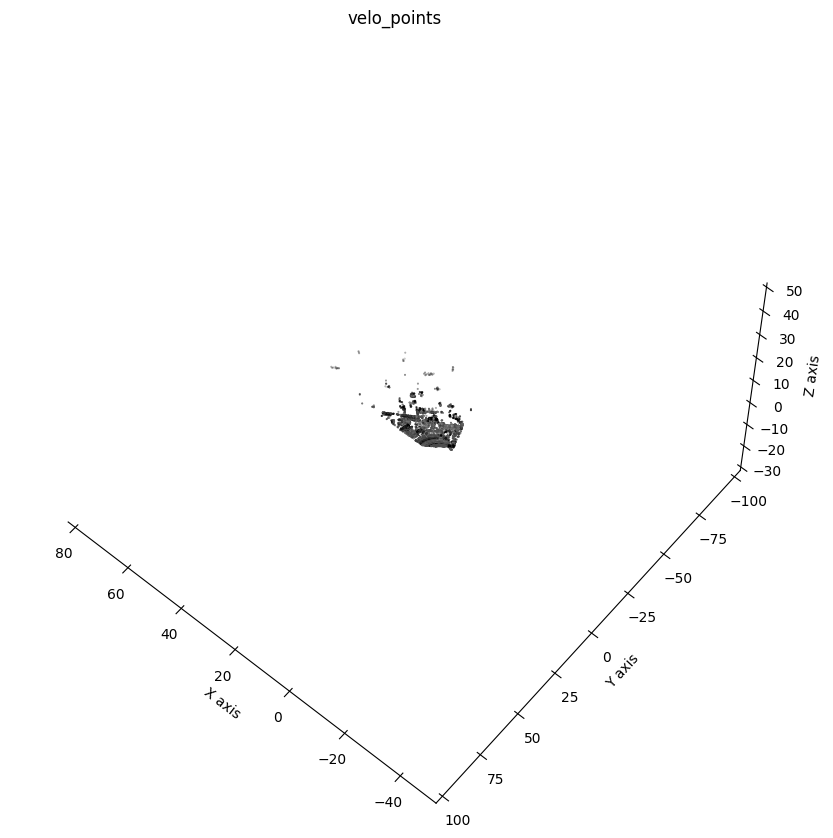

In [21]:
data = DataSet(dataset_root,'train')

init = data[0]

# 获取数据集中的点云数据
point_cloud = init['pc']

# 绘制3D点云数据，创建一个大小为20*10的图形画板
fig = plt.figure(figsize=(20, 10))
# 在画板中添加1*1的网格的第一个子图，为3D图像
ax = fig.add_subplot(111, projection='3d')
# 改变绘制图像的视角，即相机的位置，elev为Z轴角度，azim为(x,y)角度
ax.view_init(60,130)
# 在画板中画出点云显示数据，point_cloud[::x]x值越大，显示的点越稀疏

# draw_point_cloud(ax,init_pc[::5],"init_pc")
draw_point_cloud(ax, point_cloud[::5], "velo_points")

In [22]:
def judge_difficulty():
    # bbox = annotation_dict['bbox']  # # 四个数分别是xmin、ymin、xmax、ymax（单位：pixel），表示2维边界框的左上角和右下角的坐标。
    bbox = np.array([[6.32, 545.46, 134.24, 601.28]])
    height = bbox[:, 3] - bbox[:, 1]
    print(height)
    MIN_HEIGHTS = [40, 25, 25]
    difficultys = []
    for h in height:
        difficulty = -1
        for i in range(2, -1, -1):
            print(MIN_HEIGHTS[i])
            # box的框高度越大，就越困难
            if h > MIN_HEIGHTS[i]:
                difficulty = i
        difficultys.append(difficulty)
        print(difficulty)
    return np.array(difficultys, dtype=np.int)

judge_difficulty()

[55.82]
25
25
40
0


/tmp/ipykernel_61363/103728699.py:17: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



array([0])